In [1]:
import nltk; 
import time
import os

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from string import digits
from string import punctuation
import unidecode


In [3]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [4]:
import spacy


In [5]:
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['linkremoved','usernameremoved','<usernameremoved>','<linkremoved>','usernameremoved_usernameremoved','linkremoved_linkremoved'])
##stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Import data

In [7]:
file_name = 'english_collection_2.pkl'



In [8]:
df  = pd.read_pickle('../data/cambridge_analytica/'+file_name)

In [9]:
len(df)

491757

In [10]:
pd.set_option('display.max_colwidth', -1)

In [11]:
df.head()

,id,created_at,user.screen_name,user_location,coordinates,text,full_text,retweet_created_at,retweet_full_text,texto_completo
created_at2,,,,,,,,,,
2018-04-22,id-988078771453480961,Sun Apr 22 15:35:11 +0000 2018,badwolf303,Behind Enemy lines,NaN,@realDonaldTrump How much of that is taxpayer $ &amp;\nhow much in #rubles ? https://t.co/agK8DXeBl0,<usernameremoved> How much of that is taxpayer $ &amp;\nhow much in #rubles ? <linkremoved>,NaN,NaN,@realDonaldTrump How much of that is taxpayer $ &amp;\nhow much in #rubles ? https://t.co/agK8DXeBl0
2018-04-22,id-988079016233095169,Sun Apr 22 15:36:09 +0000 2018,imperienytt,NaN,NaN,@I_Kond @benimmo People who use phrases like the Kremlin Narrative are usually themselves paid shills. https://t.co/mlJMcbPmod,<usernameremoved> <usernameremoved> People who use phrases like the Kremlin Narrative are usually themselves paid shills. <linkremoved>,NaN,NaN,@I_Kond @benimmo People who use phrases like the Kremlin Narrative are usually themselves paid shills. https://t.co/mlJMcbPmod
2018-04-22,id-988079046591332359,Sun Apr 22 15:36:16 +0000 2018,MegnHarmony,"Cascade Mountains, Washington",NaN,@scolderscholar @Dbo2353 @EdKrassen Well how interesting. Doing some freelance research for Cambridge Analytica or something?,<usernameremoved> <usernameremoved> <usernameremoved> Well how interesting. Doing some freelance research for Cambridge Analytica or something?,NaN,NaN,@scolderscholar @Dbo2353 @EdKrassen Well how interesting. Doing some freelance research for Cambridge Analytica or something?
2018-04-22,id-988079064740122624,Sun Apr 22 15:36:21 +0000 2018,damu_mainali,Nepal,NaN,Is anyone want to make a whatapp group for sharing travel experience? ? \nMine whatapp is +9779808262524 https://t.co/vnBmJ9LUd0,Is anyone want to make a whatapp group for sharing travel experience? ? \nMine whatapp is +9779808262524\n#traveltheworld #WhatsApp #Facebook #group #tourism #TravelSkills #travelblog #travellers #Tourist #JoinUS #TwitterSmarter #bloggerswanted #email,NaN,NaN,Is anyone want to make a whatapp group for sharing travel experience? ? \nMine whatapp is +9779808262524\n#traveltheworld #WhatsApp #Facebook #group #tourism #TravelSkills #travelblog #travellers #Tourist #JoinUS #TwitterSmarter #bloggerswanted #email
2018-04-22,id-988078964894728192,Sun Apr 22 15:35:57 +0000 2018,wickedsmartface,United States,NaN,"@brooklynmarie Yeah, because it's more fun to have your data sold to third parties. Right on, Zuckerberg.","<usernameremoved> Yeah, because it's more fun to have your data sold to third parties. Right on, Zuckerberg.",NaN,NaN,"@brooklynmarie Yeah, because it's more fun to have your data sold to third parties. Right on, Zuckerberg."


In [12]:
df['text'] = df['texto_completo']

# Remover links

In [13]:
df['text'].replace({"http\\S+": '<linkremoved>'}, inplace=True, regex=True)

In [14]:
for texto in df['text'][0:5]:
    print(texto)


@realDonaldTrump  How much of that is taxpayer $ &amp;
how much in #rubles ? <linkremoved>
@I_Kond @benimmo People who use phrases like the Kremlin Narrative are usually themselves paid shills. <linkremoved>
@scolderscholar @Dbo2353 @EdKrassen Well how interesting. Doing some freelance  research for Cambridge Analytica or something?
Is anyone want to  make a whatapp group  for sharing travel experience? ? 
Mine whatapp is +9779808262524
#traveltheworld #WhatsApp #Facebook #group #tourism #TravelSkills #travelblog #travellers #Tourist #JoinUS #TwitterSmarter #bloggerswanted #email
@brooklynmarie Yeah, because it's more fun to have your data sold to third parties. Right on, Zuckerberg.


# remove usernames

In [15]:
df['text'].replace({"@[^\\s]+": '<usernameremoved>'}, inplace=True, regex=True)

# remove duplicates - Quizas esto debieramos no hacerlo. Deben haber bots que publican lo mismo

In [16]:
df.drop_duplicates(['text'],keep='first', inplace=True)

In [17]:
len(df)

491757

In [18]:
# numero de usuarios
tweets_by_user_data = df.groupby('user.screen_name').agg('size').sort_values(ascending=False).reset_index()
len(tweets_by_user_data)

230794

# remove digits, puntuaactions, symbols

In [19]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [20]:
punctuation+='¡¿'

In [21]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~¡¿'

In [22]:
#Remove digits and puntuaction
remove_digits = str.maketrans(digits, ' '*len(digits))#remove_digits = str.maketrans('', '', digits)
remove_punctuation = str.maketrans(punctuation, ' '*len(punctuation))#remove_punctuation = str.maketrans('', '', punctuation)
remove_hashtags_caracter = str.maketrans('#', ' '*len('#'))
#las palabras de los hashtag se mantiene, pero no el simbolo. 

In [23]:
import unidecode

data = []
for tweet in df['text']:
    tweet = tweet.translate(remove_digits)
    #tweet = tweet.lower() it wasn't a good idea,, we lost a lot of
    tweet = tweet.translate(remove_punctuation)
    tweet = tweet.translate(remove_hashtags_caracter)
    tweet = tweet.lower()
    tweet = unidecode.unidecode(tweet)
    #tweet = tweet.strip().split()
    #filtered_words = [word for word in tweet if word not in stopWords]
    #corpus[id_tweet]= filtered_words
    #id_tweet+=1
    data.append(tweet)


In [24]:
data[0:5]

[' usernameremoved   how much of that is taxpayer    amp \nhow much in  rubles    linkremoved ',
 ' usernameremoved   usernameremoved  people who use phrases like the kremlin narrative are usually themselves paid shills   linkremoved ',
 ' usernameremoved   usernameremoved   usernameremoved  well how interesting  doing some freelance  research for cambridge analytica or something ',
 'is anyone want to  make a whatapp group  for sharing travel experience    \nmine whatapp is               \n traveltheworld  whatsapp  facebook  group  tourism  travelskills  travelblog  travellers  tourist  joinus  twittersmarter  bloggerswanted  email',
 ' usernameremoved  yeah  because it s more fun to have your data sold to third parties  right on  zuckerberg ']

In [25]:
len(data)

491757

# Twitter tokenizer

In [26]:
from nltk.tokenize import TweetTokenizer

In [27]:
tknzr = TweetTokenizer()
def sent_to_words(sentences):
    for sentence in sentences:
        yield(tknzr.tokenize(sentence))


In [28]:
data_words = list(sent_to_words(data))


# Create bigram and trigram models

In [29]:
# Build the bigram and trigram models
#quizas el min count es muy bajo
#documentaicon de bigramas 
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#3importpackages
min_count = int(len(df)*0.02)
bigram = gensim.models.Phrases(data_words, min_count=min_count, threshold=1) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], min_count =min_count, threshold=1)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[1]]])

['usernameremoved_usernameremoved', 'people', 'who', 'use', 'phrases', 'like', 'the', 'kremlin', 'narrative', 'are', 'usually', 'themselves', 'paid', 'shills', 'linkremoved']


In [30]:
# See trigram example
#print(trigram_mod[bigram_mod[data_words[1]]])
for i in range(0,5):
    print(trigram_mod[bigram_mod[data_words[i]]])

['usernameremoved', 'how', 'much', 'of', 'that', 'is', 'taxpayer', 'amp', 'how', 'much', 'in', 'rubles', 'linkremoved']
['usernameremoved_usernameremoved', 'people', 'who', 'use', 'phrases', 'like', 'the', 'kremlin', 'narrative', 'are', 'usually', 'themselves', 'paid', 'shills', 'linkremoved']
['usernameremoved_usernameremoved', 'usernameremoved', 'well', 'how', 'interesting', 'doing', 'some', 'freelance', 'research', 'for', 'cambridge_analytica', 'or', 'something']
['is', 'anyone', 'want', 'to', 'make', 'a', 'whatapp', 'group', 'for', 'sharing', 'travel', 'experience', 'mine', 'whatapp', 'is', 'traveltheworld', 'whatsapp', 'facebook', 'group', 'tourism', 'travelskills', 'travelblog', 'travellers', 'tourist', 'joinus', 'twittersmarter', 'bloggerswanted', 'email']
['usernameremoved', 'yeah', 'because', 'it_s', 'more', 'fun', 'to', 'have', 'your', 'data', 'sold', 'to', 'third', 'parties', 'right', 'on', 'zuckerberg']


# Remove stopwords, make bigrams and lemmatize

In [31]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


In [32]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [33]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)


In [34]:
data_words_nostops[0]

['much', 'taxpayer', 'amp', 'much', 'rubles']

In [35]:
%pprint
data_words_nostops[0:10]

Pretty printing has been turned OFF


[['much', 'taxpayer', 'amp', 'much', 'rubles'], ['people', 'use', 'phrases', 'like', 'kremlin', 'narrative', 'usually', 'paid', 'shills'], ['well', 'interesting', 'freelance', 'research', 'cambridge', 'analytica', 'something'], ['anyone', 'want', 'make', 'whatapp', 'group', 'sharing', 'travel', 'experience', 'mine', 'whatapp', 'traveltheworld', 'whatsapp', 'facebook', 'group', 'tourism', 'travelskills', 'travelblog', 'travellers', 'tourist', 'joinus', 'twittersmarter', 'bloggerswanted', 'email'], ['yeah', 'fun', 'data', 'sold', 'third', 'parties', 'right', 'zuckerberg'], ['google', 'far', 'worse', 'enabler', 'sketchy', 'data', 'use', 'ads', 'targeting', 'facebook', 'ever', 'glad', 'someone', 'like', 'knows', 'world', 'actually', 'works', 'reporting', 'short', 'version', 'google', 'cuddly', 'company', 'might', 'think'], ['kick', 'abusive', 'people', 'putin', 'trolls', 'bots', 'social', 'media', 'reporting', 'gdpr', 'brexit', 'kremlingate', 'fakenews'], ['fuuuuck', 'im', 'creeped', 'fuck

In [36]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)



In [37]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
!python -m spacy download en

[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
v¡nculo simb¢lico creado para C:\ProgramData\Anaconda3\lib\site-packages\spacy\data\en <<===>> C:\ProgramData\Anaconda3\lib\site-packages\en_core_web_sm
[+] Linking successful
C:\ProgramData\Anaconda3\lib\site-packages\en_core_web_sm -->
C:\ProgramData\Anaconda3\lib\site-packages\spacy\data\en
You can now load the model via spacy.load('en')


You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [38]:

nlp = spacy.load('en', disable=['parser', 'ner'])

In [39]:

#sera mejor ocupar wordnetlemattizer?
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['much', 'taxpayer', 'amp', 'much', 'ruble']]


In [40]:
data_lemmatized[0]

['much', 'taxpayer', 'amp', 'much', 'ruble']

In [41]:
data_lemmatized[1]

['people', 'use', 'phrase', 'usually', 'pay', 'shill']

In [42]:
data_lemmatized[9]

['good', 'analysis', 'company', 'earn', 'keep', 'product', 'survive', 'thank', 'advertising', 'apple']

# Create dictionary and corpus for topic modeling

In [43]:
#The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1)]]


In [44]:
id2word[0]

'amp'

In [45]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]


[[('amp', 1), ('much', 2), ('ruble', 1), ('taxpayer', 1)]]

In [46]:
from gensim.test.utils import common_corpus, common_dictionary

In [47]:
from gensim.models.wrappers import LdaMallet

In [48]:
path_to_mallet_binary = "C:\\mallet\\bin\\mallet"

In [49]:
import os
os.environ.update({'MALLET_HOME':r'C:\mallet'}) #OJO!, por alguna razon mallet solo puede estar disponible en esa carpeta


# Calcular mejor numero de topicos

In [59]:
lista_num_topics = [2,5,6,8,11,15]
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    
    #modificar aqui la lista de valores en las que se desea probar
    
    #for num_topics in range(start, limit, step):
    for num_topics in lista_num_topics:
        model = gensim.models.wrappers.LdaMallet(path_to_mallet_binary, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [60]:
start = time.time()
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=1, limit=41, step=10)
#ojo, el numero de start, limit y step no tiene sentido en la linea anterior, se modifican directamente en el algoritmo
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))


00:28:16.72


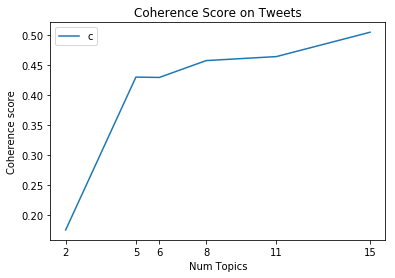

In [61]:
# Show graph

#x = range(start, limit, step)

x = lista_num_topics
plt.title("Coherence Score on Tweets")
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.xticks(x, x)

plt.legend(("coherence_values"), loc='best')
plt.show()

In [62]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.1746
Num Topics = 5  has Coherence Value of 0.4301
Num Topics = 6  has Coherence Value of 0.4295
Num Topics = 8  has Coherence Value of 0.4577
Num Topics = 11  has Coherence Value of 0.4644
Num Topics = 15  has Coherence Value of 0.5051


# Verificar rango

In [50]:
lista_num_topics = [8,9,10,11,12,13,14,15]
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    
    #modificar aqui la lista de valores en las que se desea probar
    
    #for num_topics in range(start, limit, step):
    for num_topics in lista_num_topics:
        model = gensim.models.wrappers.LdaMallet(path_to_mallet_binary, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [51]:
start = time.time()
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=1, limit=41, step=10)
#ojo, el numero de start, limit y step no tiene sentido en la linea anterior, se modifican directamente en el algoritmo
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))


00:37:20.84


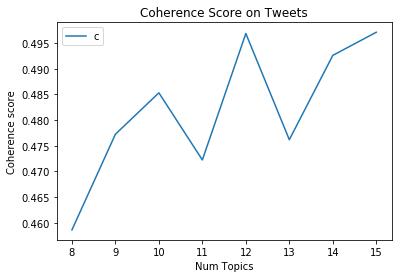

In [52]:
# Show graph

#x = range(start, limit, step)

x = lista_num_topics
plt.title("Coherence Score on Tweets")
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.xticks(x, x)

plt.legend(("coherence_values"), loc='best')
plt.show()

In [53]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 8  has Coherence Value of 0.4586
Num Topics = 9  has Coherence Value of 0.4773
Num Topics = 10  has Coherence Value of 0.4853
Num Topics = 11  has Coherence Value of 0.4722
Num Topics = 12  has Coherence Value of 0.4969
Num Topics = 13  has Coherence Value of 0.4762
Num Topics = 14  has Coherence Value of 0.4926
Num Topics = 15  has Coherence Value of 0.4971


# Build LDA Mallet Model

In [54]:
num_topic = 15

In [55]:
start = time.time()


ldamallet = LdaMallet(path_to_mallet_binary, corpus=corpus, num_topics=num_topic, id2word=id2word)

end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

00:05:09.86


In [56]:
# Show Topics
#pprint(ldamallet.show_topics(formatted=False, num_topics=num_topics))
pprint(ldamallet.show_topics(num_topics=num_topic, num_words=10, log=False, formatted=True))


[(0,
  '0.041*"trump" + 0.025*"call" + 0.022*"family" + 0.022*"child" + 0.018*"man" '
  '+ 0.016*"retweete" + 0.015*"care" + 0.014*"woman" + 0.014*"policy" + '
  '0.013*"country"'),
 (1,
  '0.071*"facebook" + 0.052*"twitter" + 0.044*"read" + 0.040*"page" + '
  '0.036*"follow" + 0.032*"video" + 0.030*"bad" + 0.029*"check" + 0.018*"link" '
  '+ 0.016*"article"'),
 (2,
  '0.148*"trump" + 0.029*"lie" + 0.018*"stop" + 0.017*"hate" + 0.017*"support" '
  '+ 0.016*"supporter" + 0.016*"conservative" + 0.016*"president" + '
  '0.011*"attack" + 0.011*"wrong"'),
 (3,
  '0.237*"datum" + 0.078*"user" + 0.060*"give" + 0.048*"company" + '
  '0.048*"share" + 0.030*"access" + 0.028*"sell" + 0.027*"personal" + '
  '0.025*"information" + 0.022*"data"'),
 (4,
  '0.127*"privacy" + 0.041*"late" + 0.038*"change" + 0.022*"law" + '
  '0.021*"security" + 0.020*"issue" + 0.019*"hack" + 0.018*"problem" + '
  '0.017*"update" + 0.015*"protect"'),
 (5,
  '0.044*"ad" + 0.038*"election" + 0.035*"campaign" + 0.033*"leav

In [57]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.49835000140223495


### Save elements from topic model

In [58]:
from gensim.models.wrappers import LdaMallet
from gensim.models.wrappers.ldamallet import malletmodel2ldamodel

In [59]:
ldamodel = malletmodel2ldamodel(ldamallet) #esto es temporal, 

In [60]:
type(ldamodel)

<class 'gensim.models.ldamodel.LdaModel'>

In [61]:
ldamallet.save('collection_2_mallet.model')
ldamodel.save('collection_2_gensim.model')

In [62]:
#corpus
import pickle
with open('collection_2_corpus.pkl', 'wb') as f:
    pickle.dump(corpus, f)

In [63]:
#id2word
id2word.save("collection_2_id2word")

# Mapear text con clean text

In [64]:
df.head(1)

,id,created_at,user.screen_name,user_location,coordinates,text,full_text,retweet_created_at,retweet_full_text,texto_completo
created_at2,,,,,,,,,,
2018-04-22,id-988078771453480961,Sun Apr 22 15:35:11 +0000 2018,badwolf303,Behind Enemy lines,NaN,<usernameremoved> How much of that is taxpayer $ &amp;\nhow much in #rubles ? <linkremoved>,<usernameremoved> How much of that is taxpayer $ &amp;\nhow much in #rubles ? <linkremoved>,NaN,NaN,@realDonaldTrump How much of that is taxpayer $ &amp;\nhow much in #rubles ? https://t.co/agK8DXeBl0


In [65]:
data[0]

' usernameremoved   how much of that is taxpayer    amp \nhow much in  rubles    linkremoved '

In [66]:
df["clean_text"] = data


In [67]:
df.head()

,id,created_at,user.screen_name,user_location,coordinates,text,full_text,retweet_created_at,retweet_full_text,texto_completo,clean_text
created_at2,,,,,,,,,,,
2018-04-22,id-988078771453480961,Sun Apr 22 15:35:11 +0000 2018,badwolf303,Behind Enemy lines,NaN,<usernameremoved> How much of that is taxpayer $ &amp;\nhow much in #rubles ? <linkremoved>,<usernameremoved> How much of that is taxpayer $ &amp;\nhow much in #rubles ? <linkremoved>,NaN,NaN,@realDonaldTrump How much of that is taxpayer $ &amp;\nhow much in #rubles ? https://t.co/agK8DXeBl0,usernameremoved how much of that is taxpayer amp \nhow much in rubles linkremoved
2018-04-22,id-988079016233095169,Sun Apr 22 15:36:09 +0000 2018,imperienytt,NaN,NaN,<usernameremoved> <usernameremoved> People who use phrases like the Kremlin Narrative are usually themselves paid shills. <linkremoved>,<usernameremoved> <usernameremoved> People who use phrases like the Kremlin Narrative are usually themselves paid shills. <linkremoved>,NaN,NaN,@I_Kond @benimmo People who use phrases like the Kremlin Narrative are usually themselves paid shills. https://t.co/mlJMcbPmod,usernameremoved usernameremoved people who use phrases like the kremlin narrative are usually themselves paid shills linkremoved
2018-04-22,id-988079046591332359,Sun Apr 22 15:36:16 +0000 2018,MegnHarmony,"Cascade Mountains, Washington",NaN,<usernameremoved> <usernameremoved> <usernameremoved> Well how interesting. Doing some freelance research for Cambridge Analytica or something?,<usernameremoved> <usernameremoved> <usernameremoved> Well how interesting. Doing some freelance research for Cambridge Analytica or something?,NaN,NaN,@scolderscholar @Dbo2353 @EdKrassen Well how interesting. Doing some freelance research for Cambridge Analytica or something?,usernameremoved usernameremoved usernameremoved well how interesting doing some freelance research for cambridge analytica or something
2018-04-22,id-988079064740122624,Sun Apr 22 15:36:21 +0000 2018,damu_mainali,Nepal,NaN,Is anyone want to make a whatapp group for sharing travel experience? ? \nMine whatapp is +9779808262524\n#traveltheworld #WhatsApp #Facebook #group #tourism #TravelSkills #travelblog #travellers #Tourist #JoinUS #TwitterSmarter #bloggerswanted #email,Is anyone want to make a whatapp group for sharing travel experience? ? \nMine whatapp is +9779808262524\n#traveltheworld #WhatsApp #Facebook #group #tourism #TravelSkills #travelblog #travellers #Tourist #JoinUS #TwitterSmarter #bloggerswanted #email,NaN,NaN,Is anyone want to make a whatapp group for sharing travel experience? ? \nMine whatapp is +9779808262524\n#traveltheworld #WhatsApp #Facebook #group #tourism #TravelSkills #travelblog #travellers #Tourist #JoinUS #TwitterSmarter #bloggerswanted #email,is anyone want to make a whatapp group for sharing travel experience \nmine whatapp is \n traveltheworld whatsapp facebook group tourism travelskills travelblog travellers tourist joinus twittersmarter bloggerswanted email
2018-04-22,id-988078964894728192,Sun Apr 22 15:35:57 +0000 2018,wickedsmartface,United States,NaN,"<usernameremoved> Yeah, because it's more fun to have your data sold to third parties. Right on, Zuckerberg.","<usernameremoved> Yeah, because it's more fun to have your data sold to third parties. Right on, Zuckerberg.",NaN,NaN,"@brooklynmarie Yeah, because it's more fun to have your data sold to third parties. Right on, Zuckerberg.",usernameremoved yeah because it s more fun to have your data sold to third parties right on zuckerberg


# Highest topic per tweet

In [ ]:
def format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(20)

In [ ]:
len(df_dominant_topic)

In [ ]:
df_topic_sents_keywords

#  Find the most representative tweets for each topic

In [ ]:
# Group top 5 sentences under each topic
numero_de_tweets_por_topico = 100


sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic') # esta matriz contiene todos los tweets con el porcentaje de contribucion y max topico. se agrupa y se obtiene lo q queremos

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(numero_de_tweets_por_topico)], 
                                            axis=0)


# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet


In [ ]:
sent_topics_sorteddf_mallet.head()

In [ ]:
sent_topics_sorteddf_mallet.rename(columns={"Text": "clean_text"},inplace=True)

In [ ]:
sent_topics_sorteddf_mallet

# find original text - username- created at

In [ ]:
sent_topics_sorteddf_mallet = pd.merge(sent_topics_sorteddf_mallet, df, on='clean_text', how='left')


In [ ]:
from datetime import datetime

In [ ]:
#ignorar para la vis por ahora
#sent_topics_sorteddf_mallet.to_csv("Topic_Modeling_num_topics_"+str(num_topic)+"_"+datetime.now().strftime("%Y_%m_%d_%H_%M")+".csv")

In [ ]:
sent_topics_sorteddf_mallet

In [ ]:
type(sent_topics_sorteddf_mallet)

In [ ]:
#corpus
import pickle
with open('collection_2_sent_topics_sorteddf_mallet_ldamodel', 'wb') as f:
    pickle.dump(sent_topics_sorteddf_mallet, f)

# Topic distribution across documents

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords.drop_duplicates(subset='Dominant_Topic', keep='first').sort_values(by=['Dominant_Topic']).reset_index(drop=True), topic_counts.sort_index(), topic_contribution.sort_index()], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']



In [ ]:
#funciona perfecto
df_dominant_topics

# Visualize topics with Mallet

In [188]:
prueba = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)


In [189]:
pyLDAvis.enable_notebook()


In [190]:
data = pyLDAvis.gensim.prepare(prueba, corpus,id2word, mds='pcoa')


C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


KeyboardInterrupt: 

In [ ]:
type(data)

In [ ]:
#data.to_
pyLDAvis.save_html(data, "Topic_Modeling_num_topics_"+str(num_topic)+"_"+datetime.now().strftime("%Y_%m_%d_%H_%M")+".html")


In [197]:
data

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
1      0.046732 -0.211374  1       1        6.764875
14     0.130426 -0.028817  2       1        6.761233
8     -0.071498  0.205806  3       1        6.733116
3      0.012480  0.248749  4       1        6.720660
2      0.058090 -0.039805  5       1        6.702762
6      0.081515 -0.127699  6       1        6.701299
13    -0.234947  0.075870  7       1        6.697635
9      0.122400  0.093161  8       1        6.668188
11     0.121017 -0.015839  9       1        6.659189
0     -0.278366 -0.029842  10      1        6.646311
12     0.089094  0.090891  11      1        6.635778
4      0.069843 -0.001360  12      1        6.621511
10     0.099445  0.105084  13      1        6.592423
7     -0.307783 -0.113728  14      1        6.590168
5      0.061553 -0.251097  15      1        6.504852, topic_info=      Category          Freq             Term         Total  loglift  logprob
term                                                                         
7      Default  14729.000000  toquedequeda     14729.000000  30.0000  30.0000
1106   Default  6634.000000   pinerarenuncia   6634.000000   29.0000  29.0000
241    Default  6620.000000   poblar           6620.000000   28.0000  28.0000
5      Default  6223.000000   querer           6223.000000   27.0000  27.0000
3      Default  7763.000000   gente            7763.000000   26.0000  26.0000
0      Default  6423.000000   decir            6423.000000   25.0000  25.0000
258    Default  8775.000000   chiledesperto    8775.000000   24.0000  24.0000
97     Default  4748.000000   dar              4748.000000   23.0000  23.0000
516    Default  4578.000000   renunciapinera   4578.000000   22.0000  22.0000
194    Default  4415.000000   chileno          4415.000000   21.0000  21.0000
223    Default  7852.000000   hacer            7852.000000   20.0000  20.0000
306    Default  4336.000000   militar          4336.000000   19.0000  19.0000
167    Default  4180.000000   pinera           4180.000000   18.0000  18.0000
181    Default  4008.000000   chilesecanso     4008.000000   17.0000  17.0000
407    Default  3516.000000   hoy              3516.000000   16.0000  16.0000
93     Default  4719.000000   ver              4719.000000   15.0000  15.0000
115    Default  3400.000000   hablar           3400.000000   14.0000  14.0000
38     Default  4369.000000   ir               4369.000000   13.0000  13.0000
19301  Default  3074.000000   estopasaenchile  3074.000000   12.0000  12.0000
149    Default  5398.000000   solo             5398.000000   11.0000  11.0000
90     Default  3368.000000   quedo            3368.000000   10.0000  10.0000
15     Default  5248.000000   ahora            5248.000000   9.0000   9.0000 
25     Default  2937.000000   milicos          2937.000000   8.0000   8.0000 
43     Default  2930.000000   creer            2930.000000   7.0000   7.0000 
34     Default  2687.000000   saber            2687.000000   6.0000   6.0000 
151    Default  2640.000000   violencia        2640.000000   5.0000   5.0000 
22     Default  4131.000000   estan            4131.000000   4.0000   4.0000 
210    Default  2576.000000   salir            2576.000000   3.0000   3.0000 
436    Default  2517.000000   social           2517.000000   2.0000   2.0000 
231    Default  2485.000000   hora             2485.000000   1.0000   1.0000 
...        ...          ...      ...                   ...      ...      ... 
432    Topic15  1186.408337   chileseaburrio   1187.426120   2.7318  -3.7406 
16875  Topic15  832.065082    chadwickasesino  832.065082    2.7326  -4.0954 
1443   Topic15  794.557996    chiledespierta   794.557996    2.7326  -4.1415 
5636   Topic15  729.414111    chileprotestas   729.414111    2.7326  -4.2270 
3255   Topic15  727.440054    chilequierepaz   727.440054    2.7326  -4.2297 
3187   Topic15  708.686511    chileprotests    708.686511    2.7326  -4.2558 
810    Topic15